# Greek Mythology Project: Code File

In this document you will find the following: <br>
- [Necessary imports](#Necessary-imports)
- [Data Acquisition](#Data-Acquisition)
- [Preprocessing](#Preprocessing)
- [Data Exploration](#Data-Exploration) 
- [Model](#Model) + [Word Embeddings](#Word-Embeddings)
- [Data Visualisation](#Data-Visualisation)

## Necessary imports

In [1]:
import numpy as np
import nltk
import json
import urllib
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
with open('mortaldict.json', 'r') as f:
    mortaldict = json.load(f)
    
with open('goddict.json', 'r') as f:
    goddict = json.load(f)

## Data Acquisition

All our texts will be extracted from the website [theoi](https://www.theoi.com/). It contains almost all of the original texts of Greek Mythology translated into English. In this project, we have decided to extract some of the more popular stories, namely; [Homer Odysee](#Homer-Odysee) , [The Iliad](#The-Iliad) , [The Fall of Troy](#The-Fall-of-Troy) , and the [Ovid Metamorphosis](#Ovid-Metamorphosis).

#### Homer Odysee

In [3]:
Odysee_URL = "https://www.theoi.com/Text/HomerOdyssey1.html"
Odysee_page = requests.get(Odysee_URL)
Odysee_soup = BeautifulSoup(Odysee_page.content, "html.parser")

#visual part of text
Odysee_soup.get_text()[4000:4500]

"ather of gods and men was first to speak, for in his heart he thought of noble Aegisthus, whom far-famed Orestes, Agamemnon's son, had slain. Thinking on him he spoke among the immortals, and said: “Look you now, how ready mortals are to blame the gods. It is from us, they say, that evils come, but they even of themselves, through their own blind folly, have sorrows beyond that which is ordained. Even as now Aegisthus, beyond that which was ordained, took to himself the wedded wife of the son of"

#### The Iliad

In [4]:
Iliad_URL = "https://www.theoi.com/Text/HomerIliad1.html"
Iliad_page = requests.get(Iliad_URL)
Iliad_soup = BeautifulSoup(Iliad_page.content, "html.parser")

#visual part of text
Iliad_soup.get_text()[4000:4500]

'not protect you. Her I will not set free. Sooner shall old age come upon her in our house, in Argos, far from her native land, as she walks to and fro before the loom and serves my bed. But go, do not anger me, that you may return the safer."\n[33] So he spoke, and the old man was seized with fear and obeyed his word. He went forth in silence along the shore of the loud-resounding sea, and earnestly then, when he had gone apart, the old man prayed\xa0to the lord Apollo, whom fair-haired Leto bore: "'

#### The Fall of Troy

In [5]:
Troy_URL = "https://www.theoi.com/Text/QuintusSmyrnaeus1.html"
Troy_page = requests.get(Troy_URL)
Troy_soup = BeautifulSoup(Troy_page.content, "html.parser")

#visual part of text
Troy_soup.get_text()[4000:4500]

" she mid that charging host. Clonie was there, Polemusa, Derinoe, Evandre, and Antandre, and Bremusa, Hippothoe, dark-eyed Harmothoe, Alcibie, Derimacheia, Antibrote, and Thermodosa glorying with the spear. All these to battle fared with warrior-souled Penthesileia: even as when descends Dawn from Olympus' crest of adamant, Dawn, heart-exultant in her radiant steeds amidst the bright-haired Hours; and o'er them all, how flawless-fair soever these may be, her splendour of beauty glows pre-eminent"

#### Ovid Metamorphosis

In [6]:
OvidM_URL = "https://www.theoi.com/Text/OvidMetamorphoses1.html"
OvidM_page = requests.get(OvidM_URL)
OvidM_soup = BeautifulSoup(OvidM_page.content, "html.parser")

#visual part of text
OvidM_soup.get_text()[4000:4500]

'aste. It was a rude and undeveloped mass, that nothing made except a ponderous weight; and all discordant elements confused, were there congested in a shapeless heap. As yet the sun afforded earth no light, nor did the moon renew her crescent horns; the earth was not suspended in the air exactly balanced by her heavy weight. Not far along the margin of the shores had Amphitrite stretched her lengthened arms,—for all the land was mixed with sea and air. The land was soft, the sea unfit to sail, t'

Now that we have the starting pages of all 4 stories, we will have to find a way to extract the other chapters which are linked in the home pages.  As seen in the code below, the links to the other chapthers (called BOOKS), always have the following format: <br> 
< a href="HomerOdyssey1.html">BOOK 1</a >, <br>
< a href="HomerOdyssey2.html">BOOK 2</a >,


In [7]:
Odysee_soup.find_all('a')

[<a class="navbar-brand" href="https://www.theoi.com/Library.html">Theoi Project - Classical Texts Library</a>,
 <a href="../Library.html">LIBRARY HOME</a>,
 <a href="https://www.theoi.com/">GREEK MYTHOLOGY</a>,
 <a aria-expanded="false" aria-haspopup="true" class="dropdown-toggle" data-toggle="dropdown" href="#" role="button">GREEK GODS<span class="caret"></span></a>,
 <a href="../greek-mythology/olympian-gods.html">Olympian Gods</a>,
 <a href="../greek-mythology/primeval-gods.html">Primordial Gods</a>,
 <a href="../greek-mythology/titans.html">Titan Gods</a>,
 <a href="../greek-mythology/sky-gods.html">Sky Gods</a>,
 <a href="../greek-mythology/sea-gods.html">Sea Gods</a>,
 <a href="../greek-mythology/rustic-gods.html">Rustic Gods</a>,
 <a href="../greek-mythology/underworld-gods.html">Underworld Gods</a>,
 <a href="../greek-mythology/personifications.html">Daemones-Spirits</a>,
 <a href="../greek-mythology/nymphs.html">Nymphs</a>,
 <a href="../greek-mythology/greek-gods.html">more &

Now that we know what we are looking for, we will create a list which has all the links to the different chapters which we can then loop through later.  

In [8]:
Websites = []

#Odysee
for link in Odysee_soup.find_all('a'):
    if "HomerOdyssey" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Iliad
for link in Iliad_soup.find_all('a'):
    if "HomerIliad" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Troy
for link in Troy_soup.find_all('a'):
    if "QuintusSmyrnaeus" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Ovid-Metamorphosis
for link in OvidM_soup.find_all('a'):
    if link.get('href') == None:
        continue
    elif "OvidMetamorphoses" in link.get('href') and not '#' in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))    

#visualise all the chapters
for web in Websites:
    print(web)

https://www.theoi.com/Text/HomerOdyssey1.html
https://www.theoi.com/Text/HomerOdyssey2.html
https://www.theoi.com/Text/HomerOdyssey3.html
https://www.theoi.com/Text/HomerOdyssey4.html
https://www.theoi.com/Text/HomerOdyssey5.html
https://www.theoi.com/Text/HomerOdyssey6.html
https://www.theoi.com/Text/HomerOdyssey7.html
https://www.theoi.com/Text/HomerOdyssey8.html
https://www.theoi.com/Text/HomerOdyssey9.html
https://www.theoi.com/Text/HomerOdyssey10.html
https://www.theoi.com/Text/HomerOdyssey11.html
https://www.theoi.com/Text/HomerOdyssey12.html
https://www.theoi.com/Text/HomerOdyssey13.html
https://www.theoi.com/Text/HomerOdyssey14.html
https://www.theoi.com/Text/HomerOdyssey15.html
https://www.theoi.com/Text/HomerOdyssey16.html
https://www.theoi.com/Text/HomerOdyssey17.html
https://www.theoi.com/Text/HomerOdyssey18.html
https://www.theoi.com/Text/HomerOdyssey19.html
https://www.theoi.com/Text/HomerOdyssey20.html
https://www.theoi.com/Text/HomerOdyssey21.html
https://www.theoi.com/

Now that we have all the html links to the chapters of the books we want to use, we will scrape the text off them and combind it all into one list.

In [9]:
full_text = []
for link in Websites:
    p = requests.get(link)
    s = BeautifulSoup(p.content, "html.parser")
    full_text.append(s.get_text())
    #print(s.title) #check which books have been printed


Finally, we will save the list which contains the full text of all 4 stories into a txt file so it can be used by the other group mates.

In [10]:
#save full_text to txt file to import to preprocessing 

textfile = open("text_file.txt", "w")
for element in full_text:
    textfile.write(element + "\n")
textfile.close()

## Preprocessing

First, let's check what the encoding is of the text file, so that we can properly import the texts

As can be seen above, this file doesn't use the standard utf-8 encoding, but cp1252 encoding. So, we will use this encoder when reading it in:

We split the data into sentences

In [90]:
sentences = []
for par in full_text:
    if par == '\n':
        continue
    senttemp = sent_tokenize(par)
    sentences = sentences +senttemp

print(sentences[100:105])

['Come now, give ear, and hearken to my words.', 'On the morrow call to an assembly the Achaean lords, and speak out thy word to all, and let the gods be thy witnesses.', 'As for the wooers, bid them scatter, each to his own; and for thy mother, if her heart bids her marry, let her go back to the hall of her mighty father, and there they will prepare a wedding feast, and make ready the gifts full many—aye, all that should follow after a well-loved daughter.', 'And to thyself will I give wise counsel, if thou wilt hearken.', '[280]\xa0"Man with twenty rowers the best ship thou hast, and go to seek tidings of thy father, that has long been gone, if haply any mortal may tell thee, or thou mayest hear a voice from Zeus, which oftenest brings tidings to men.']


Now, we tokenize the sentences. If the sentence consists of two words or less, we remove it since it won't contain much useful information. Also, this way we might be able to filter out as many chapter titles as possible.

In [91]:
words = []
for sent in sentences:
    wordstemp = word_tokenize(sent)
    if len(wordstemp) <= 2:
        continue
    words.append(wordstemp)
    
print(words[1000])

['Grant', 'that', 'I', 'may', 'come', 'to', 'the', 'Phaeacians', 'as', 'one', 'to', 'be', 'welcomed', 'and', 'to', 'be', 'pitied.', '”', '[', '328', ']', 'So', 'he', 'spoke', 'in', 'prayer', ',', 'and', 'Pallas', 'Athena', 'heard', 'him', ';', 'but', 'she', 'did', 'not', 'yet', 'appear', 'to', 'him', 'face', 'to', 'face', ',', 'for', 'she', 'feared', 'her', 'father', "'s", 'brother', ';', 'but', 'he', 'furiously', 'raged', 'against', 'godlike', 'Odysseus', ',', 'until', 'at', 'length', 'he', 'reached', 'his', 'own', 'land', '.']


Now, we PoS tag the data, so that lemmatization is easier, and names of characters can be identified more easily

In [92]:
tagged = []
for sent in words:
    senttagged = nltk.pos_tag(sent)
    tagged.append(senttagged)

tagged_filtered = []
for sent in tagged:
    sentls = []
    for wordtag in sent:
        if wordtag[1] in ['.', ',', ':', '--', '$', '(', ')'] or wordtag[0] in ['“', '”', '<', '>']:
            continue
        else: sentls.append(wordtag)
    tagged_filtered.append(sentls)
        
print(tagged_filtered[3000:3010])

[[('HOMER', 'NNP'), ('ODYSSEY', 'NNP'), ('BOOK', 'NNP'), ('19', 'CD'), ('Theoi', 'NNP'), ('Classical', 'NNP'), ('Texts', 'NNP'), ('Library', 'NNP')], [('Toggle', 'NNP'), ('navigation', 'NN'), ('Theoi', 'NNP'), ('Project', 'NNP'), ('Classical', 'JJ'), ('Texts', 'NNP'), ('Library', 'NNP'), ('LIBRARY', 'NNP'), ('HOME', 'NNP'), ('GREEK', 'NNP'), ('MYTHOLOGY', 'NNP'), ('GREEK', 'NNP'), ('GODS', 'NNP'), ('Olympian', 'NNP'), ('Gods', 'NNP'), ('Primordial', 'NNP'), ('Gods', 'NNP'), ('Titan', 'NNP'), ('Gods', 'NNP'), ('Sky', 'NNP'), ('Gods', 'NNP'), ('Sea', 'NNP'), ('Gods', 'NNP'), ('Rustic', 'NNP'), ('Gods', 'NNP'), ('Underworld', 'NNP'), ('Gods', 'NNP'), ('Daemones-Spirits', 'NNP'), ('Nymphs', 'NNP'), ('more', 'RBR'), ('BESTIARY', 'NNP'), ('HEROES', 'NNP'), ('MISCELLANY', 'NNP'), ('Gods', 'NNP'), ('Spirits', 'NNP'), ('&', 'CC'), ('Monsters', 'NNP'), ('A-Z', 'NNP'), ('Family', 'NNP'), ('Tree', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Gods', 'NNP'), ('Legendary', 'NNP'), ('Tribes', 'NNP'), ('Lege

Next, we lemmatize the dataset

In [93]:
# Reference for lemmatizing: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

lemmatizer = WordNetLemmatizer()

lemmatized = []
for sent in tagged_filtered:
    
    sentls = []
    for wordtag in sent:
        tag = ''
        if wordtag[1][0:2] ==  'NN':
            tag =  'n'
        elif wordtag[1][0:2] ==  'VB':
            tag =  'v'
        elif wordtag[1][0:2] ==  'JJ':
            tag =  'a'
        elif wordtag[1][0:2] ==  'RB':
            tag =  'r'
        
        # use postag if it exists in the wordnetlemmatizer
        if tag == '': lemma = lemmatizer.lemmatize(wordtag[0])
        else: lemma = lemmatizer.lemmatize(wordtag[0], pos=tag)
        
        sentls.append([lemma, wordtag[1]])
    lemmatized.append(sentls)
    
print(lemmatized[3000:3010])

[[['HOMER', 'NNP'], ['ODYSSEY', 'NNP'], ['BOOK', 'NNP'], ['19', 'CD'], ['Theoi', 'NNP'], ['Classical', 'NNP'], ['Texts', 'NNP'], ['Library', 'NNP']], [['Toggle', 'NNP'], ['navigation', 'NN'], ['Theoi', 'NNP'], ['Project', 'NNP'], ['Classical', 'JJ'], ['Texts', 'NNP'], ['Library', 'NNP'], ['LIBRARY', 'NNP'], ['HOME', 'NNP'], ['GREEK', 'NNP'], ['MYTHOLOGY', 'NNP'], ['GREEK', 'NNP'], ['GODS', 'NNP'], ['Olympian', 'NNP'], ['Gods', 'NNP'], ['Primordial', 'NNP'], ['Gods', 'NNP'], ['Titan', 'NNP'], ['Gods', 'NNP'], ['Sky', 'NNP'], ['Gods', 'NNP'], ['Sea', 'NNP'], ['Gods', 'NNP'], ['Rustic', 'NNP'], ['Gods', 'NNP'], ['Underworld', 'NNP'], ['Gods', 'NNP'], ['Daemones-Spirits', 'NNP'], ['Nymphs', 'NNP'], ['more', 'RBR'], ['BESTIARY', 'NNP'], ['HEROES', 'NNP'], ['MISCELLANY', 'NNP'], ['Gods', 'NNP'], ['Spirits', 'NNP'], ['&', 'CC'], ['Monsters', 'NNP'], ['A-Z', 'NNP'], ['Family', 'NNP'], ['Tree', 'NNP'], ['of', 'IN'], ['the', 'DT'], ['Gods', 'NNP'], ['Legendary', 'NNP'], ['Tribes', 'NNP'], ['Lege

Next, we go through the data and print all the proper nouns that aren't in the dictionaries. If they are not and they refer to names of characters that are either Olympian gods or mortals, we add them to the dictionaries in the file characterdicts.ipynb. We do this only for names that occur at least 10 times in the book, since adding all names is not realistic. The below code prints the proper nouns (or words that were classified as such) that we didn't add to the dictionary. As can be seen, all of these are either not names, names of people who aren't part of mythology, or children of gods (in which case we left them out, since they are somewhere between god and mortal).

In [94]:
# Reference for sorting dictionary: https://www.edureka.co/blog/sort-dictionary-by-value-in-python/

non_occuring = {}
non_occuring_min10 = {}

mortals = mortaldict
gods = goddict

for sent in lemmatized:
    for wordtag in sent:
    
        # Only look at proper nouns
        if wordtag[1] == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx, vals in enumerate(mortals.values()):
                if wordtag[0] in vals[0]:
                    filled_in = 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx, vals in enumerate(gods.values()):
                    if wordtag[0] in vals[0]:
                        filled_in = 1
                        break

            # Print word if it hasn't been found at all
            if filled_in == 0:
                if wordtag[0] in non_occuring.keys():
                    non_occuring[wordtag[0]] += 1
                else: non_occuring[wordtag[0]] = 1

for key in non_occuring.keys():
    if non_occuring[key] >= 10:
        non_occuring_min10[key] = non_occuring[key]

for key in sorted(non_occuring_min10.keys()):
       print("%s: %s" % (key, non_occuring_min10[key]))

A: 190
A-Z: 81
A.: 67
AND: 57
ARTICLES: 81
Aaron: 81
Achaea: 40
Achaean: 56
Achaeans: 26
Achelous: 38
Achilleid: 81
Actor: 12
Aeacus: 100
Aegeus: 28
Aeneid: 81
Aeolus: 19
Aesacus: 21
Aeschylus: 567
Aeson: 23
Against: 83
Age: 11
Aglauros: 25
Ah: 100
Aiantes: 18
Alas: 30
Alcman: 81
Alexander: 49
Alexandra: 81
Alpheus: 22
Althaea: 21
Amazon: 20
Amazons: 13
Anaxarete: 18
Antenor: 32
Antimachus: 10
Antinous: 58
Apollodorus: 81
Apollonius: 81
Aratus: 81
Arethusa: 24
Argive: 76
Argives: 121
Argonautica: 162
Argos: 60
Argus: 19
Armour: 25
Arms: 15
Asius: 20
Astronomica: 81
Athamas: 22
Athens: 17
Atlas: 32
Atsma: 81
Attis: 17
Aulis: 22
Aurora: 23
Ay: 17
Aye: 65
BESTIARY: 81
BOOK: 1796
BROOKES: 16
BY: 81
Barring: 25
Battefield: 25
Battle: 51
Battlefield: 350
Battles: 30
Battus: 18
Baucis: 22
Be: 20
Bearers: 81
Beggar: 50
Beguiling: 25
Behold: 13
Bion: 81
Boar: 17
Body: 25
Book: 81
Boreas: 31
Bound: 81
Byblis: 25
CLASSICAL: 81
CONTENTS: 81
Cadmus: 58
Caeneus: 31
Caesar: 24
Callimachus: 81
Callist

## Data exploration

First, we go through the texts, and count how many times a certain name is mentioned.

In [95]:
i = 0
for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):
        word = wordtag[0]
        tag = wordtag[1]

        if tag == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx3, vals in enumerate(mortaldict.values()):
                if word in vals[0]:
                    filled_in = 1
                    mortaldict[str(idx3)][1] += 1
                    lemmatized[idx][idx2][1] = 'NNPm'
                    i += 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx4, vals in enumerate(goddict.values()):
                    if word in vals[0]:
                        filled_in = 1
                        goddict[str(idx4)][1] += 1
                        lemmatized[idx][idx2][1] = 'NNPg'
                        i += 1
                        break

Below we print the amounts of times mortals and gods are mentioned. Note that in reality this number is a bit higher because we are not looking at all mortals and all gods. While mortals are named more often, both gods and mortals are named enough times to be able to do a meaningful analysis.

In [96]:
summortals = 0
sumgods = 0

for mval in mortaldict.values():
    summortals += mval[1]
    
for gval in goddict.values():
    sumgods += gval[1]
    
print('Total amount of mortal names: ', summortals)
print('Total amount of god names: ', sumgods)

Total amount of mortal names:  18284
Total amount of god names:  8744


Next, we plot the 20 most common names for both mortals and gods. 

In [97]:
# Reference for sorting dict: https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/

sortm = list(mortaldict.values())
sortm.sort(key = lambda x: x[1])
sortm.reverse()

sortg = list(goddict.values())
sortg.sort(key = lambda x: x[1])
sortg.reverse()

In [98]:
mnames = [name[0][0] for name in sortm]
mcounts = [count[1] for count in sortm]

gnames = [name[0][0] for name in sortg]
gcounts = [count[1] for count in sortg]

As can be seen in the graphs, the most common names make sense considering the original texts. The main characters of for example the Iliad and Odyssee occur most often, and the most important gods are named the most.

Text(0.5, 1.0, '20 most common mortals and their frequencies')

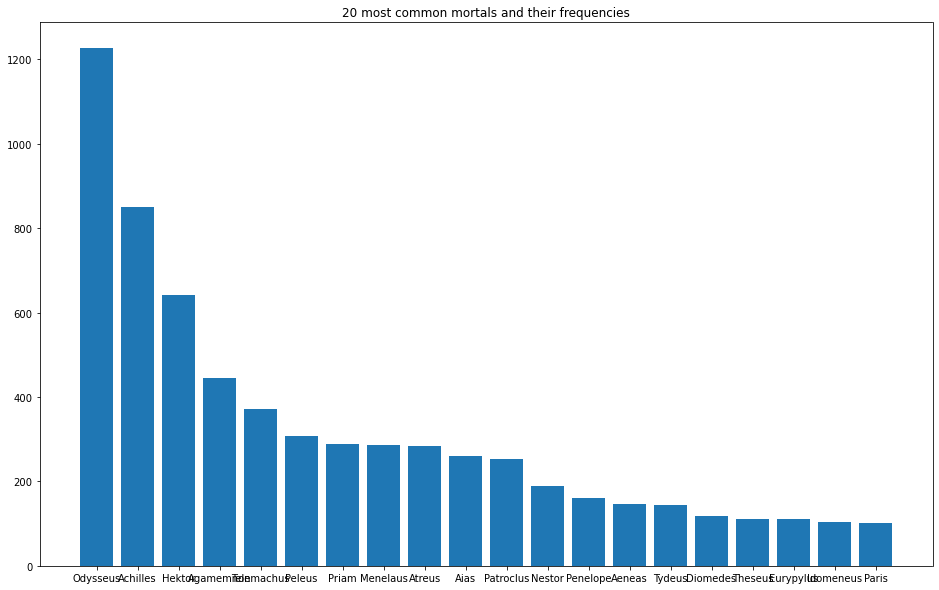

In [20]:
plt.figure(figsize=(16, 10))
plt.bar(mnames[0:20], mcounts[0:20])
plt.title('20 most common mortals and their frequencies')

Text(0.5, 1.0, '20 most common gods and their frequencies')

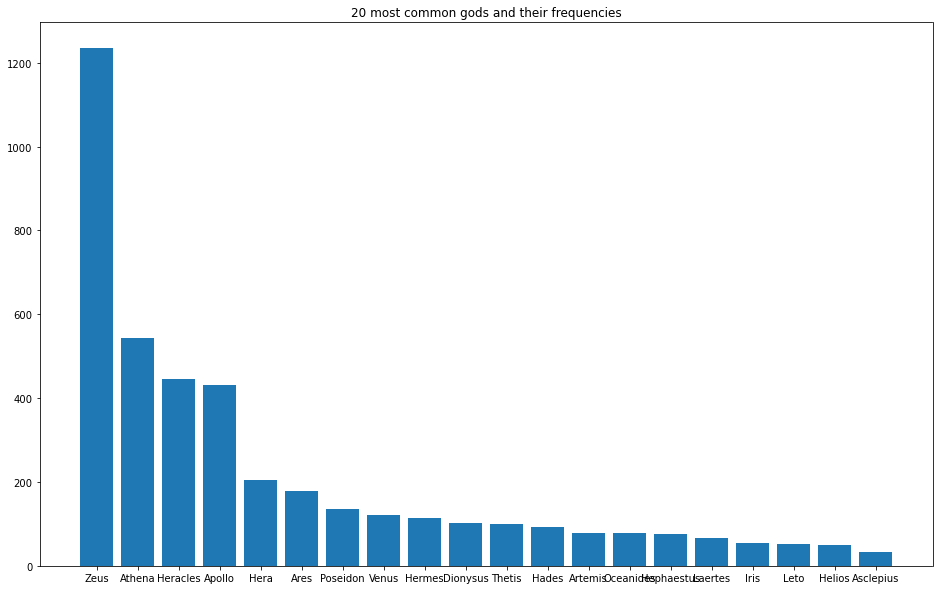

In [21]:
plt.figure(figsize=(16, 10))
plt.bar(gnames[0:20], gcounts[0:20])
plt.title('20 most common gods and their frequencies')

Next, we take the context of each name.

In [99]:
name_cons = []
for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):    
        word = wordtag[0]
        tag = wordtag[1]

        if tag == 'NNPm' or tag == 'NNPg':
            context = sent[max(0, idx2-5):idx2] + sent[idx2+1: min(len(sent), idx2+5)]
            name_cons.append([wordtag, context])

print(name_cons[100])

[['Athena', 'NNPg'], [['So', 'NNP'], ['speak', 'VBD'], ['the', 'DT'], ['goddess', 'NN'], ['flashing-eyed', 'JJ'], ['and', 'CC'], ['depart', 'VBD'], ['fly', 'VBG'], ['upward', 'RB']]]


We check whether there are enough adjectives and adverbs in the context of the names to be able to perform the analysis. 

In [100]:
advcountm = 0
adjcountm = 0
advcountg = 0
adjcountg = 0
adjcounter = Counter()

for namecon in name_cons:
    name = namecon[0]
    con = namecon[1]
    
    if name[1] == 'NNPm':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountm += 1
                adjcounter[wordtag[0]] += 1
                
            elif wordtag[1][0:2] == 'JJ':
                adjcountm += 1
                adjcounter[wordtag[0]] += 1
                
    elif name[1] == 'NNPg':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountg += 1
                adjcounter[wordtag[0]] += 1
                
            elif wordtag[1][0:2] == 'JJ':
                adjcountg += 1
                adjcounter[wordtag[0]] += 1
                
print('There are ', advcountm, ' adverbs, and ', adjcountm, ' adjectives around names of mortals.')
print('There are ', advcountg, ' adverbs, and ', adjcountg, ' adjectives around names of gods.')

There are  3645  adverbs, and  3917  adjectives around names of mortals.
There are  1533  adverbs, and  2015  adjectives around names of gods.


We consider these as enough adjectives and adverbs to perform the analysis. We will also look at the most common adjectives and adverbs to see whether there are some that are not useful for this analysis.

In [24]:
print(adjcounter.most_common(30))

[('Then', 562), ('not', 428), ('even', 364), ('goodly', 318), ('[', 242), ('now', 230), ('then', 220), ('glorious', 208), ('great', 202), ('many', 192), ('so', 165), ('first', 158), ('So', 153), ('unto', 137), ('other', 120), ('good', 115), ('thou', 114), ('flashing-eyed', 103), ('again', 103), ('verily', 101), ('dear', 99), ('old', 88), ('thy', 88), (']', 82), ('yet', 81), ('ever', 73), ('thus', 73), ('far', 71), ('strong', 68), ('valiant', 66)]


## Model

First, we will implement the Word2Vec model to see whether words around mortals are different from those around gods. Lemmatized_replace is a list of the PoS tagged data, where each name of a mortal or god is replaced by MORTALNAME or GODNAME. This way, we can clearly see the difference between gods and mortals, without having to go through all names of gods and mortals and seeing what words are most similar to them. 

In [101]:
lemmatized_replace = []

for sent in lemmatized:
    sentls = []
    for wordtag in sent:
        if wordtag[1] == 'NNPm': 
            sentls.append(['MORTALNAME', 'NNPm'])
        elif wordtag[1] == 'NNPg':
            sentls.append(['GODNAME', 'NNPg'])
        else: sentls.append(wordtag)
    lemmatized_replace.append(sentls)

print(lemmatized_replace[100])

[['On', 'IN'], ['the', 'DT'], ['morrow', 'NN'], ['call', 'NN'], ['to', 'TO'], ['an', 'DT'], ['assembly', 'NN'], ['the', 'DT'], ['Achaean', 'NNP'], ['lord', 'NNS'], ['and', 'CC'], ['speak', 'VB'], ['out', 'RP'], ['thy', 'JJ'], ['word', 'NN'], ['to', 'TO'], ['all', 'DT'], ['and', 'CC'], ['let', 'VB'], ['the', 'DT'], ['god', 'NNS'], ['be', 'VB'], ['thy', 'JJ'], ['witness', 'NNS']]


Below, we made two lists that can be used in the model. One contains all names adverbs, and adjectives. The other contains all words. We were debating which one to use in the model, which is why for now we kept both in. Right now, we are using all words as input for the model. This is because if we filter out all words except adverbs and adjectives, the windows around the target words overlap much, resulting in almost identical similarity scores for mortals and gods. We will most likely filter out all the adjectives and adverbs after retrieving the words with the highest similarity scores, so that the filtering has less of an effect on the model. <br>
We are however, already removing a few words which play a key role in the visualisation of the data in future stages. This we are only doing when we are certain the word does not add any value to the results of the model later on. 

In [102]:
advadjfilt = []
nofilt = []

#remove invaluable words
remove = ["Then", "then", "thou", "own"] 

for sent in lemmatized_replace:
    sentls = []
    sentlsfilt = []
    for word in sent:
        if word[0] in remove:
            continue
        else:
            sentls.append(word[0]) 
        
        if word[1][0:2] in ['RB', 'JJ'] or word[1] in ['NNPg', 'NNPm']:
            if word[0] in remove:
                continue
            else:
                sentlsfilt.append(word[0])
                
    advadjfilt.append(sentlsfilt)
    nofilt.append(sentls)

The parameters below were mostly taken from the notebook from week 5. We lowered the min_count, since we also want rare adjectives and adverbs to be taken into account. We also upped the amount of epochs, to prevent underfitting. However, we also did not make this number as large, because overfitting should also be prevented. 

In [103]:
params = {
    'vector_size': 100, # dimension of embeddings
    'window': 4, # window -/+ before and after focus word
    'epochs': 10, # number of iterations over the corpus
    'min_count': 2, # filter on words whose frequency is below this count
    'sg': 0, # use the skip-gram (1) or the CBOW (0) mode. In class, we presented the CBOW (predict context given focus words). See optional materials for the skip-gram (predict focus given context)
    'negative': 5, # how many negative samples to use (see optional class contents too)
    'workers': 4, # how many cores to use
    'alpha': 0.05 # initial learning rate for SGD. This is lambda in the class notes
}
model = Word2Vec(nofilt, **params)

As can be seen below, the words that are most similar to gods are different from those that are most similar to mortals, but they contain many names and words that are not adjectives or adverbs. We now make lists with specifically the most similar adverbs and adjectives to gods and mortals.

In [104]:
for word in list(model.wv.most_similar('GODNAME', topn=10)):
    print(word)

('goddess', 0.5827412009239197)
('Cronos', 0.5458405017852783)
('aegis', 0.5334458947181702)
('Atrytone', 0.5048069953918457)
('loud-thundering', 0.48686471581459045)
('Earth', 0.48285648226737976)
('Shaker', 0.4783245325088501)
('Circe', 0.4593752324581146)
('priest', 0.4568532407283783)
('nymph', 0.4446620047092438)


In [105]:
for word in list(model.wv.most_similar('MORTALNAME', topn=10)):
    print(word)

('Sarpedon', 0.6239804029464722)
('Aeacus', 0.5617942214012146)
('prince', 0.5427787899971008)
('Alexander', 0.541982889175415)
('swineherd', 0.52027428150177)
('Menoetius', 0.5163162350654602)
('Andraemon', 0.46644243597984314)
('Thrasymedes', 0.46261653304100037)
('him', 0.4624715745449066)
('king', 0.4575884938240051)


In [106]:
lemmatized_replace_words = []
lemmatized_replace_tags = []

for sent in lemmatized_replace:
    for word in sent:
        lemmatized_replace_words.append(word[0])
        lemmatized_replace_tags.append(word[1])

similarg = []
similarm = []

for word in list(model.wv.most_similar('MORTALNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    if tag[0:2] in ['RB', 'JJ']:
        similarm.append([word[0], word[1]])
    

for word in list(model.wv.most_similar('GODNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    if tag[0:2] in ['RB', 'JJ']:
        similarg.append([word[0], word[1]])

Below are the lists of the most similar adverbs and adjectives. These lists seem to make sense, since adjectives that are only for gods (like Olympian) are most similar to gods, and the other way around (godlike is much more similar to mortals, which makes sense because a god won't be described as being 'godlike'.

In [107]:
for word in similarg[:15]:
    print(word)
print('\n')
for word in similarm[:15]:
    print(word)

['loud-thundering', 0.48686471581459045]
['afar', 0.44132182002067566]
['tasselled', 0.4320235550403595]
['flashing-eyed', 0.3917333483695984]
['heaven', 0.38275861740112305]
['gracious', 0.372761994600296]
['fair-tressed', 0.370448499917984]
['ox-eyed', 0.369265079498291]
['white-armed', 0.3643948435783386]
['borne', 0.3412923812866211]
['silver-footed', 0.3249807059764862]
['keen-sighted', 0.3228577673435211]
['fair-haired', 0.31289878487586975]
['Tyrrhenian', 0.2831983268260956]
['swear', 0.281432569026947]


['wise-hearted', 0.4256581962108612]
['swift-footed', 0.40765807032585144]
['great-souled', 0.40331730246543884]
['peerless', 0.3885754346847534]
['glorious', 0.37359440326690674]
['valiant', 0.368217408657074]
['much-enduring', 0.35035303235054016]
['chariot', 0.3403862714767456]
['fair-haired', 0.33016055822372437]
['lordly', 0.324222207069397]
['fain', 0.31846126914024353]
['Laestrygonian', 0.31218671798706055]
['god-like', 0.3047299087047577]
['noble', 0.30338284373283386]


In [44]:
# look for the similar words in gods and mortals
ls1 = [x[0] for x in similarm]
ls2 = [x[0] for x in similarg]
similarGM = []
#for simgod in similarg:
 #   for simmor in similarm:
similarGM = list(set(ls1).intersection(ls2))
print(similarGM)

['Now', 'victorious', 'wise-hearted', 'far-famed', 'willingly', 'Fearful', 'afterward', 'unworthy', 'far', 'war-loving', 'heaven', 'illustrious', 'harshly', 'dawn-rose', 'Niobe', 'loud-thundering', 'daybreak', 'battle-prowess', 'wide-gated', 'Up', 'supinely', 'terribly', 'shrewd', 'lore', 'sixth', 'long-robed', 'far-seeing', 'easily', 'high-throned', 'churlish', 'fair-haired', 'overthrown', 'anywise', 'sore-tried', '—these', 'alone', 'war-renowned', 'orderly', 'proud', 'unmanly-souled', 'stout-hearted', 'bringest', 'followed', 'somewhat', 'terrible', 'fairly', 'farmstead', 'twin', 'attest', 'modest', 'lordly', 'fair-towered', 'forth', 'fatherless', 'unmarked', 'least', 'uncontested', 'most', 'Alcinous', 'warrior-wasting', 'already', 'unlamented', 'unavailing', 'minded', 'near', 'even', 'fleet-winged', 'first', 'tear-besprinkled', 'reputed', 'unto', 'timely', 'for.', 'aforetime', 'willing', 'painfully', 'god-like', 'elder-born', 'Narycian', 'well-built', 'Also', 'fitly', 'glorious', 'un

The above results can be visualised in the following way to make interpretation easier. 

## Word Embeddings

In [108]:
most_common_list = []
coocu = Counter()
for sent in name_cons:
       
    target = sent[0]
    con = sent[1]
    filteredcon = []
    
    remove = ["Then", "then", "[", "]", "thy", "thou", "many", "even", "not", "now", "So", "so", 
              "thou", "ever", "other", "unto", "yet", "such", "here", "again", "there", "more", 
              "too", "such", "thus", "as", "ye", "also", "once", "thee", "far", "back", "Now", 
              "indeed", "most", "no", "away", "near", "most", "Most", "already", "only", "near"]
       
    for word in con:
        if word[0] in remove:
            continue
        else:
            filteredcon.append(word)

    for conword in filteredcon:
        if conword[1][0:2] in ['RB', 'JJ']:
            
            coocu[(target[0], conword[0])] += 1

for common in list(coocu.most_common(500)):
    most_common_list.append(common)


In [109]:
from tabulate import tabulate

# define header names
col_names = ["Character description", "Occurence"]

print(tabulate(most_common_list, headers=col_names))

Character description               Occurence
--------------------------------  -----------
('Odysseus', 'goodly')                    110
('Athena', 'flashing-eyed')                58
('Achilles', 'goodly')                     52
('Zeus', 'great')                          42
('Hector', 'goodly')                       40
('Hector', 'glorious')                     33
('Athene', 'flashing-eyed')                31
('Menelaus', 'fair-haired')                30
('Menelaus', 'good')                       27
('Achilles', 'Night-time')                 25
('Hera', 'white-armed')                    25
('Achilles', 'swift-footed')               25
('Odysseus', 'dear')                       24
('Hera', 'queenly')                        22
('Zeus', 'borne')                          21
('Zeus', 'high')                           20
('Aias', 'great')                          20
('Diomedes', 'good')                       20
('Aias', 'Telamonian')                     19
('Priam', 'old')                  

### Data Visualisation

We will make a scatter plot of the gods 

In [34]:
from sklearn.decomposition import PCA

Text(0.5, 1.0, 'Most Similar Adverbs and Adjectives for Gods')

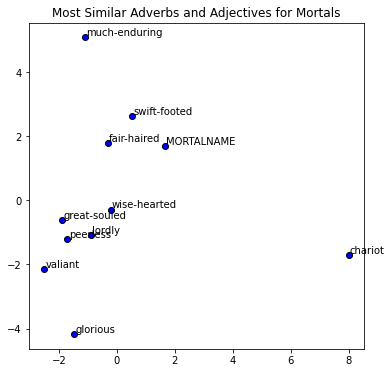

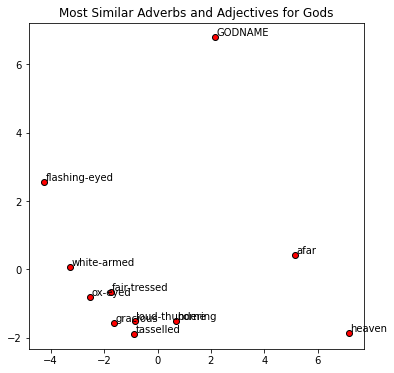

In [149]:
#MORTAL
def display_pca_scatterplot(model, color, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    # do PCA on the selected embeddings
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
        
display_pca_scatterplot(model.wv, 'blue',
                        ['MORTALNAME']+[x[0] for x in similarm[:10]])
plt.title("Most Similar Adverbs and Adjectives for Mortals")
      
display_pca_scatterplot(model.wv, 'red',
                        ['GODNAME']+[x[0] for x in similarg[:10]])
plt.title("Most Similar Adverbs and Adjectives for Gods")

TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 720x720 with 0 Axes>

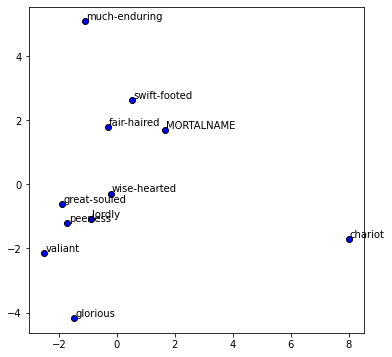

In [158]:
plt.figure(figsize=(10,10))
plt.scatter(display_pca_scatterplot(model.wv, 'blue',
                        ['MORTALNAME']+[x[0] for x in similarm[:10]]))
plt.scatter(display_pca_scatterplot(model.wv, 'red',
                        ['GODNAME']+[x[0] for x in similarg[:10]]), display_pca_scatterplot(model.wv, 'red',
                        ['GODNAME']+[x[0] for x in similarg[:10]]))
plt.show()